In [81]:
import numpy as np; import matplotlib.pyplot as plt
import pymc3 as pm; from scipy import stats; import pandas as pd ;import os 
import theano; import seaborn as sns; from theano import shared, tensor as tt
from numpy import pi
# Age, Age Error, 40Ar, 39Ar, 37Ar, 36Ar, Temperature
cwd = os.chdir("/Users/jackcarter/Documents/Data_Mixtures")
df = pd.read_csv("mix_hb_acs.csv", engine = 'python')

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


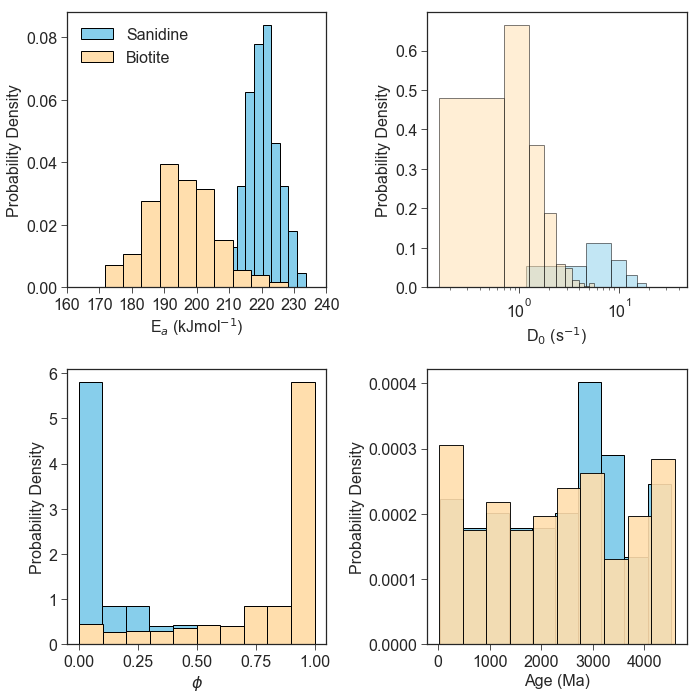

In [82]:
# Prior Plot for all Variables
sns.set_style('ticks')
font = {"family": "Arial", 
      "size": 16, 
      "weight": "normal"}

plt.rc("font", **font)

z = np.random.normal(220, 5, 500)
zz = np.random.lognormal(2, 0.5, 1000)

age = np.random.uniform(0, 4600, 100)
age2 = np.random.uniform(0, 4600, 100)


ea_bio = np.random.normal(196, 10, 500)
d0_bio = np.random.lognormal(0.01, 0.63, 500)
phi_bio = np.random.dirichlet((0.2, 0.8), size = 1000)
fig, ax = plt.subplots(2,2, figsize = (10, 10))
ax[0,0].hist(z, normed = True, bins = 10, 
        edgecolor = 'k', 
        facecolor = 'skyblue', 
            label = 'Sanidine')

ax[0,0].hist(ea_bio, normed = True, bins = 10, 
        edgecolor = 'k', 
        facecolor = 'navajowhite', 
            label = 'Biotite')

ax[0,0].set_xlabel('E$_a$ (kJmol$^{-1}$)')
ax[0,0].set_ylabel('Probability Density')
# To specify the number of ticks on both or any single axes
ax[0,0].locator_params(axis='y', nbins=8)
ax[0,0].locator_params(axis='x', nbins=8)
ax[0,0].set_xlim(160, 240)




ax[0,1].hist(zz, normed = True, bins = 10, 
        edgecolor = 'k', 
        facecolor = 'skyblue', 
            alpha = 0.5)

ax[0,1].hist(d0_bio, normed = True, bins = 10, 
        edgecolor = 'k', 
        facecolor = 'navajowhite', 
            alpha = 0.5)

ax[0,1].set_xlabel('D$_0$ (s$^{-1}$)')
ax[0,1].set_ylabel('Probability Density')
# To specify the number of ticks on both or any single axes
ax[0,1].locator_params(axis='y', nbins=8)
ax[0,1].locator_params(axis='x', nbins=8)
ax[0,1].set_xscale('log')


ax[1,0].hist(phi_bio[:,0], normed = True, bins = 10, 
        edgecolor = 'k', 
        facecolor = 'skyblue')
ax[1,0].hist(phi_bio[:,1], normed = True, bins = 10, 
        edgecolor = 'k', 
        facecolor = 'navajowhite')

ax[1,0].set_xlabel('$\phi$')
ax[1,0].set_ylabel('Probability Density')




ax[1,1].hist(age2, normed = True, bins = 10, 
        edgecolor = 'k', 
        facecolor = 'skyblue')

ax[1,1].hist(age, normed = True, bins = 10, 
        edgecolor = 'k', 
        facecolor = 'navajowhite', alpha = 0.9)
ax[1,1].set_xlabel('Age (Ma)')
ax[1,1].set_ylabel('Probability Density')
# To specify the number of ticks on both or any single axes
ax[1,1].locator_params(axis='y', nbins=8)
ax[1,1].locator_params(axis='x', nbins=8)

ax[0,0].legend()

plt.tight_layout()

In [83]:
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False

    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)


def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.

    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5

    # cast tau and sigma to float in a way that works for both np.arrays
    # and pure python
    tau = 1. * tau
    sigma = 1. * sigma

    return floatX(tau), floatX(sigma)


class Sum_of_Squares(pm.distributions.Continuous):

    def __init__(self, mu=0, sigma=None, tau=None, sd=None, **kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)

        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau

        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')

        super().__init__(**kwargs)

    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        
        logp = - tt.sqr(value - mu)/(2.0 * sigma *sigma)
        return logp.sum()


In [84]:
temp = df['Temperature (Degrees Celcius)'].values
age = df['Age'].values
age_err = df['Age Error'].values
ar39 = df['39Ar'].values
ar39_Err = df['39Ar_Err'].values
time = 300*np.ones(len(temp))

In [85]:
def frel(a): 
    y = np.cumsum(a)
    z = y/y.max()
    return z

In [86]:
ww = frel(ar39)


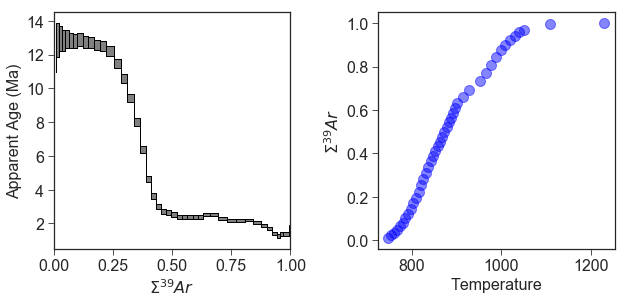

In [87]:
sns.set_style('ticks')
fig, ax = plt.subplots(1,2, figsize = (9, 4.5))

ax[0].fill_between(ww, age - age_err, age + age_err, 
        step = 'pre', facecolor = 'grey',
                  edgecolor = 'k', interpolate = False)
for i in range(len(age)):
    ax[0].vlines(ww, age - age_err, age + age_err,
          color= 'k', lw = 1)
ax[1].plot(temp, ww, 'or', 
          color = 'blue', alpha = .48, markersize = 10)

ax[0].set_xlim(0, 1)

ax[0].set_ylabel('Apparent Age (Ma)')
ax[0].set_xlabel('$\Sigma^{39}Ar$')

ax[1].set_xlabel('Temperature')
ax[1].set_ylabel('$\Sigma^{39}Ar$')

plt.tight_layout()

In [88]:
"""
Create Shared 
variables and data to be used in
the model 
"""
ww = frel(ar39)
R = 8.314e-3
tk = temp + 273.15
time = 300*np.ones(len(tk))
a_err = shared(age_err*2)
N = age.shape[0]
data3 = ww
data1 = age

In [89]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - (np.sqrt(np.pi)*bb2/a**2)))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T



def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

In [91]:
W = pm.Model() 
with W: 
    
    """
    Mixing fraction term 
    """
    phi = pm.Dirichlet('phi',
                       a = np.array([0.5, 0.5]), 
                      shape = 2)
    """
    Assign mixing fraction to a parameter
    """
    
    p1 = phi[0]
    p2 = phi[1]
    
    """
    Activation Energy Prior
    """
    ea1 = pm.Normal('ea1',
                    mu = 196,
                    sd = 16)
    
    ea2 = pm.Normal('ea2', 
                    mu = 220,
                    sd = 9)
    
    """
    Frequency Factor Prior
    """
    
    lnd01 = pm.Normal('lnd01', mu = -2.6, sd = 1.9)
    
    
    lnd02 = pm.Normal('lnd02', mu = 8.4,
                      sd = 1)
    
    d01 = pm.Deterministic('d01', np.exp(lnd01))
    
    d02 = pm.Deterministic('d02',np.exp(lnd02) * (0.02**2))
    

    
    """
    Effective Diffusion Radius 
    ~ (radii of grain)
    """ 
    a1 = pm.Uniform('a1',
                    lower = 0.001, 
                    upper = 0.0032)
    
    a2 = pm.Uniform('a2',
                    lower = 0.001, 
                    upper = 0.0032)

In [92]:
with W: 
    d01_trace = pm.Deterministic('d01_trace', np.exp(lnd01))
    d02_trace = pm.Deterministic('d02_trace', np.exp(lnd02))

In [93]:
with W: 
    """
    Age prior for each component 
    - Uniform between 0 - 4600 Ma
    """
    age1 = pm.Uniform('age1', lower = 0.0, 
                    upper = 4600, 
                     testval= 40)
   
    age2= pm.Uniform('age2', lower = 0.0, 
                   upper = 4600, 
                    testval = 5)

    

In [94]:
with W:
    # Mixture weights
    w1 = p1
    w2 = p2
    """
    Create Incremental Release Curves with 
    Temperature and Time schedule and the 
    diffusion kinetics 
    """
    X = Increment(ea1, d01, a1, tk, time)
    Y = Increment(ea2, d02, a2, tk, time)
    
    """
    Create Variables to print them in the 
    trace
    """
    YY = pm.Deterministic('YY', Y)
    XX = pm.Deterministic('XX', X)

    qq = w1*X + w2*Y
    mix1 = ((w1*X)/(qq))
    mix2 = ((w2*Y)/(qq))

In [95]:
with W:    
    """
    Model Fractional release 
    with temperature time and
    the diffusion kinetics 
    """
    A = fracrelx(ea1, d01, a1, tk, time)
    B = fracrelx(ea2, d02, a2, tk, time)
    A = pm.Deterministic('A', A)
    B = pm.Deterministic('B', B)
    """
    Fractional Release Model 
    """
    mu1 = w1*A + w2*B
    

 ############################################################################
    """
    Force Monotonic Constraint
    - Seems to imporve efficiency of sampling
    """
    for i in range(len(tk) - 1): 
        fracrel_cons = pm.Potential(f'frel_cons{i}', 
                                       tt.switch(A[i + 1] - A[i] < 0, 
                                                 -np.inf, 0) + 
                                       tt.switch(B[i + 1] - B[i] < 0, 
                                                -np.inf, 0)) 
        
    # Add Monontonic Constraints to all fractional release 
    for i in range(len(tk) - 1): 
        fracrel_cons = pm.Potential(f'frel_consbb{i}', 
                                       tt.switch(mu1[i + 1] - mu1[i] < 0, 
                                                 -np.inf, 0) + 
                                   tt.switch(mu1.max() > 1, -np.inf, 0))
###########################################################################
    """
    Print model in trace
    """ 
    model1 = pm.Deterministic('model1', mu1)

    """
    Create Error Vector for fractional Release
    """
    f_err1 = pm.HalfNormal('f_err1',
                           sd = 0.1, 
                           shape = N) 
    
    

In [96]:
with W:     
    """
    Age Equation for 2 components 
    """
    mu2 = ((w1*X*age1)/(w1*X + w2*Y)) + ((w2*Y*age2)/(w1*X + w2*Y))
    
    # Model Trace
    model2 = pm.Deterministic('model2', mu2)
    
    age_err = pm.HalfNormal('age_err', 
                           sd = 2, 
                           shape = N)


In [97]:
with W: 
    # Age Spectra Likelihood 
    obs1 = Sum_of_Squares('obs1', mu = mu2, 
                    sd = age_err, 
                    observed = data1)
    
    # Cumulative Release Likelihood
    obs2 = pm.Normal('obs2', 
                    mu = mu1, 
                    sd = f_err1, 
                    observed = data3)
    

In [98]:
with W: 
    # Get logprobabilities of each model 
    log1 = pm.Deterministic('log1', obs1.logpt)
    log2 = pm.Deterministic('log2', obs2.logpt)

# Check Test Probabilities

In [99]:
W.check_test_point()

a1_interval__           -1.39
a2_interval__           -1.39
age1                    -0.23
age2                     1.67
age_err_log__          -33.11
ea1                     -3.69
ea2                     -3.12
f_err1_log__           -33.11
lnd01                   -1.56
lnd02                   -0.92
obs1                  -605.13
obs2                   -17.69
phi_stickbreaking__     -1.84
Name: Log-probability of test_point, dtype: float64

In [100]:
SEED = np.random.seed(123)
SAMPLES = 100000
BURN = 200000
with W: 
    
    step1 = pm.NUTS([phi], 
                   target_accept = 0.75)
    
    step2 = pm.Metropolis([ea1, ea2, 
                           d01, d02,
                           f_err1, 
                          age1, age2])
    
    
    step3 = pm.Metropolis([a1, a2, 
                          d01, d02])

    
    trace = pm.sample(SAMPLES, 
                      tune = BURN,  
                      step = pm.Metropolis(),  
                     random_seed = SEED,
                     cores = 3, 
                     chains = 3)

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [age_err]
>Metropolis: [f_err1]
>Metropolis: [age2]
>Metropolis: [age1]
>Metropolis: [a2]
>Metropolis: [a1]
>Metropolis: [lnd02]
>Metropolis: [lnd01]
>Metropolis: [ea2]
>Metropolis: [ea1]
>Metropolis: [phi]
Sampling 3 chains: 100%|██████████| 900000/900000 [1:29:15<00:00, 56.88draws/s]  
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


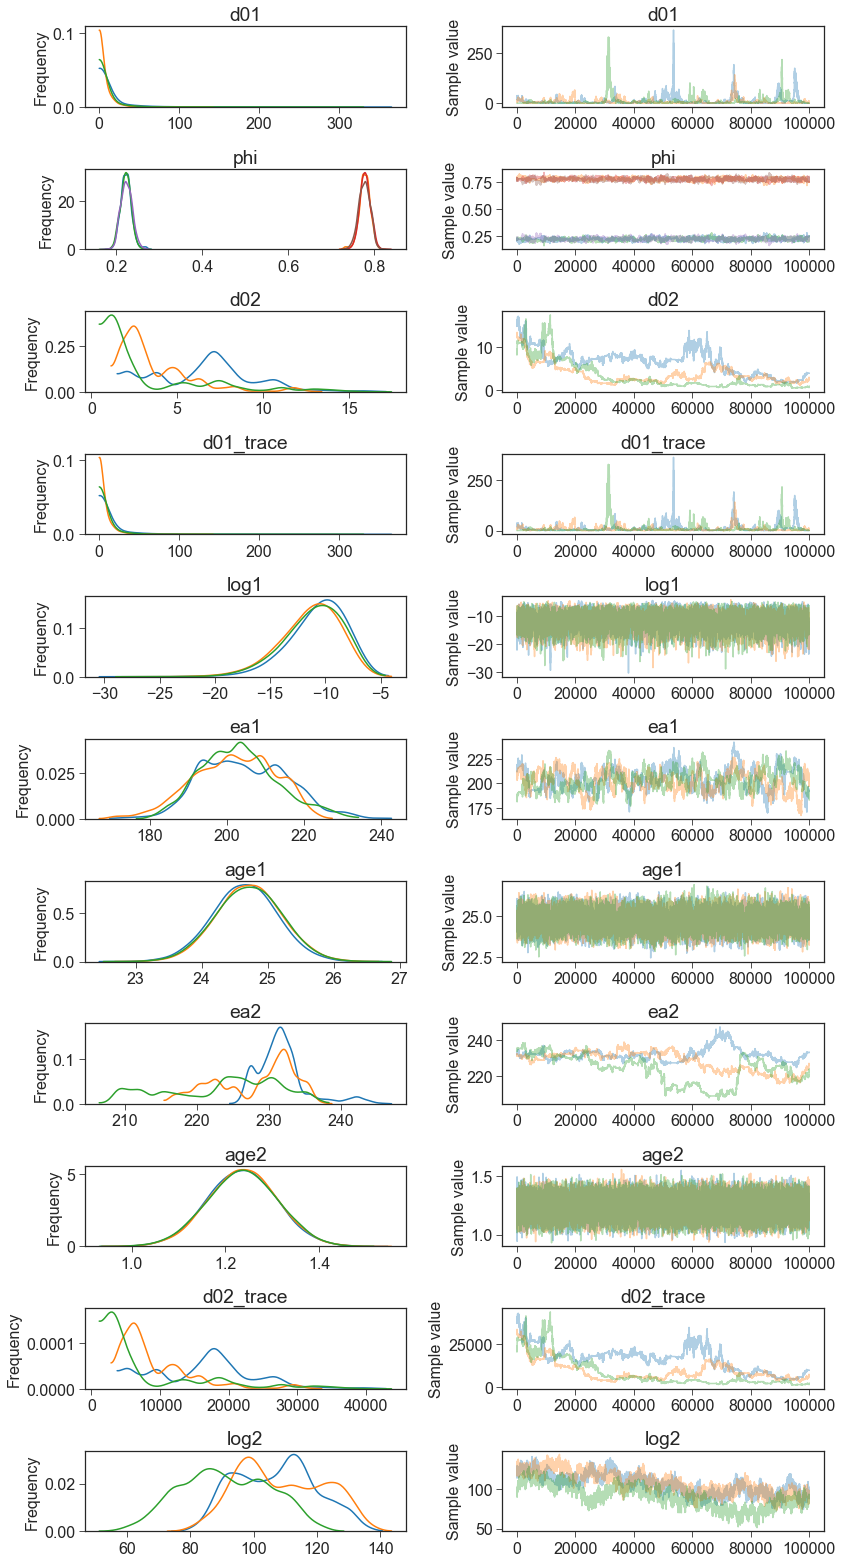

In [101]:
sns.set_style('ticks')
font = {"family": "Arial", 
      "size": 16, 
      "weight": "normal"}

plt.rc("font", **font)
pm.traceplot(trace, 
            varnames = {'phi','ea1', 'ea2', 
                  'd01_trace', 'd02_trace', 
                  'age1', 'age2',
                       'd01', 'd02', 
                       'log1', 'log2'});  

# Get Ages

In [102]:
def ln_like(model, data, err): 
    """
    Sum of Squares Likelihood
    """
    return -0.5 * np.sum(np.log(2 * np.pi * err ** 2)
            + ((data - model) / err)**2)

In [103]:
model1 = trace['model1']
err1 = trace['f_err1']
log1 = []
for i in range(100000):
    logx = ln_like(model1[i],data3,err1[i])
    
    log1.append(logx)

In [104]:
model2 = trace['model2']
err2 = trace['age_err']
log2 = []
for i in range(100000):
    logx = ln_like(model2[i],data1,err2[i])
    
    log2.append(logx)

In [105]:
print(trace['age1'].mean(axis = 0), 
      trace['age2'].mean(axis = 0))
print(trace['age1'].std(axis = 0),
      trace['age2'].std(axis = 0))

24.68916296467863 1.2350455719518505
0.49065701050651955 0.07374366406401384


# Post Posterior Model

* Sample from full trace
* Randomly take 10000

In [106]:
with W: 
    ppc = pm.sample_ppc(trace, 10000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 10000/10000 [01:55<00:00, 86.94it/s]


In [107]:
f_low, f_high = np.percentile(ppc['obs2'],
                              [2.5, 97.5],
                              axis = 0)

age_mod_low, age_mod_high = np.percentile(ppc['obs1'], 
                                         [2.5, 97.5], 
                                         axis = 0)

zz1 = ppc['obs2'].mean(axis = 0)
zz2 = ppc['obs1'].mean(axis = 0)

In [108]:
# Plotting Parameters
data2 = ww
data = age
age_low_plot = np.insert(age_mod_low, 0, age_mod_low[0])
age_high_plot = np.insert(age_mod_high, 0, age_mod_high[0])
f_mod_plot = np.insert(zz1, 0, 0)
age_err = df['Age Error'].values

model_plot = np.insert(zz2, 0, zz2[0])

data_err_plot = np.insert(age_err, 0, age_err[0])
data_plot = np.insert(age, 0, age[0])
f_plot = np.insert(data2, 0, 0)

# Full Model

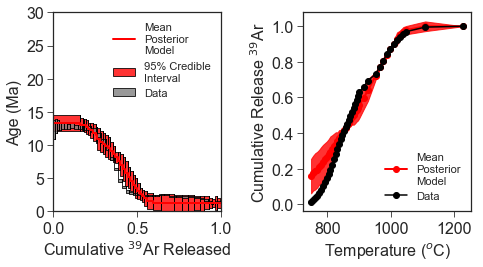

In [109]:
fig, ax = plt.subplots(1, 2, figsize = (7, 4))
ww = data2
ax[0].fill_between(f_mod_plot, age_low_plot, 
                  age_high_plot, 
                  step = 'pre',  
                  alpha = 0.8, 
                  facecolor = 'r', 
                  label = '95% Credible\nInterval', 
                  edgecolor = 'k')

ax[0].plot(f_mod_plot, model_plot, 'r-', 
          lw = 2, 
          label = 'Mean\nPosterior\nModel', 
          drawstyle = 'steps')


ax[0].fill_between(f_plot, data_plot + data_err_plot,
                   data_plot - data_err_plot, 
        step = 'pre', alpha = 0.8, facecolor = 'grey',
          edgecolor = 'k', 
                  label = 'Data')

for i in range(len(data)): 
    ax[0].vlines(f_mod_plot, age_low_plot, 
                  age_high_plot, color = 'k', lw= 0.7)

for i in range(len(data)): 
    ax[0].vlines(f_plot, data_plot + data_err_plot,
                   data_plot - data_err_plot,  color = 'k', lw= 0.7)

ax[1].fill_between(temp, f_low, f_high, 
                  color = 'r', alpha = 0.8)

ax[1].plot(temp, zz1, '-or', 
          lw = 2, label = 'Mean\nPosterior\nModel')
ax[1].plot(temp, ww, '-ok', 
          label = 'Data')

ax[0].set_ylim(0, 30)
ax[0].set_xlim(0, 1)


ax[0].set_xlabel('Cumulative $^{39}$Ar Released')
ax[0].set_ylabel('Age (Ma)')

ax[1].set_xlabel('Temperature ($^{o}$C)')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
ax[0].legend(fontsize = 'x-small')
ax[1].legend(fontsize = 'x-small')
plt.tight_layout()
plt.savefig('age_frac_model_xx.jpg')

# Log Probability Plot

In [110]:
logp_model = W.logp
# Every Hundreth accepted sample
logp = [logp_model(i) for i in trace[-SAMPLES::100]]

In [111]:
log1 = np.array(log1)
log1 = log1*-1

In [112]:
log2 = np.array(log2)

In [113]:
log_sum = log1 + log2

In [115]:
log_sum.shape[0]

100000

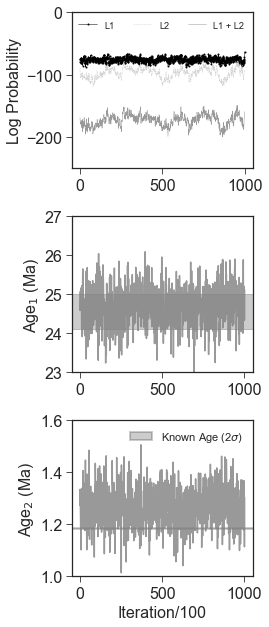

In [120]:
logp_model = W.logp
# Every Hundreth accepted sample
logp = [logp_model(i) for i in trace[-SAMPLES::100]]
# Trace Plotting
trace_plot = trace[-SAMPLES::300]

fig, ax = plt.subplots(3,1, figsize = (4, 9))
#Axis 1
ax[0].plot(log2[-100000::100],  '-o',
           color= 'k', 
          markersize = 1, 
          label = 'L1', 
          lw = 0.5)
ax[0].plot(log1[-50000::50],  
           color= 'lightgrey', 
          markersize = 1, 
          label = 'L2', ls = '--', 
          lw = 0.5)
ax[0].plot(log2[-100000::100] + log1[-50000::50], color = 'grey', 
          alpha = 0.8, 
          label= 'L1 + L2', 
          lw = 0.5)
ax[0].set_ylabel('Log Probability')


# Axis 2
ax[1].plot(trace_plot['age1'], 
          color = 'grey', 
          alpha = 0.8)
ax[1].set_ylabel('Age$_{1}$ (Ma)')
ax[1].axhspan(24.1,  25, color = 'k',
              alpha = 0.2, 
             label = 'Known Age (2$\sigma$)')



# Axis 3
ax[2].plot(trace_plot['age2'] + 0.03, 
          color = 'grey', 
          alpha = 0.8)
ax[2].set_ylabel('Age$_{2}$ (Ma)')
ax[2].axhspan(1.1848 - 0.0012, 1.1848 + 0.0012,
              lw = 2, color = 'k', 
             alpha = 0.2, 
             label = 'Known Age (2$\sigma$)')
ax[2].set_ylim(1, 1.6)
ax[2].legend(fontsize = 'x-small')

ax[1].set_ylim(23, 27)


ax[2].set_xlabel('Iteration/100')
ax[0].legend(ncol = 3,fontsize = 'xx-small')
ax[0].set_ylim(-250, 0)
plt.tight_layout()
plt.savefig('log_p_figure_2sigma.pdf')

# DataFrame for PairGrid


* For the DataFrame
* Only take every 500th sample from the full trace

In [37]:
dfx = pm.trace_to_dataframe(trace[-SAMPLES::200])
df_pairgrid = pd.DataFrame({"age1":dfx['age1'].values, 
                   "age2": dfx['age2'].values, 
                   "ea1":dfx['ea1'].values, 
                   "ea2":dfx['ea2'].values, 
                   "d01":dfx['d01'].values, 
                   "d02":dfx['d02'].values})

In [39]:
dfx = pm.trace_to_dataframe(trace[-SAMPLES::300])
df_pairgrid = pd.DataFrame({"age1":dfx['age1'].values, 
                   "age2": dfx['age2'].values, 
                   "ea1":dfx['ea1'].values, 
                   "ea2":dfx['ea2'].values, 
                   "d01":np.log(dfx['d01'].values), 
                   "d02":np.log(dfx['d02'].values)})

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


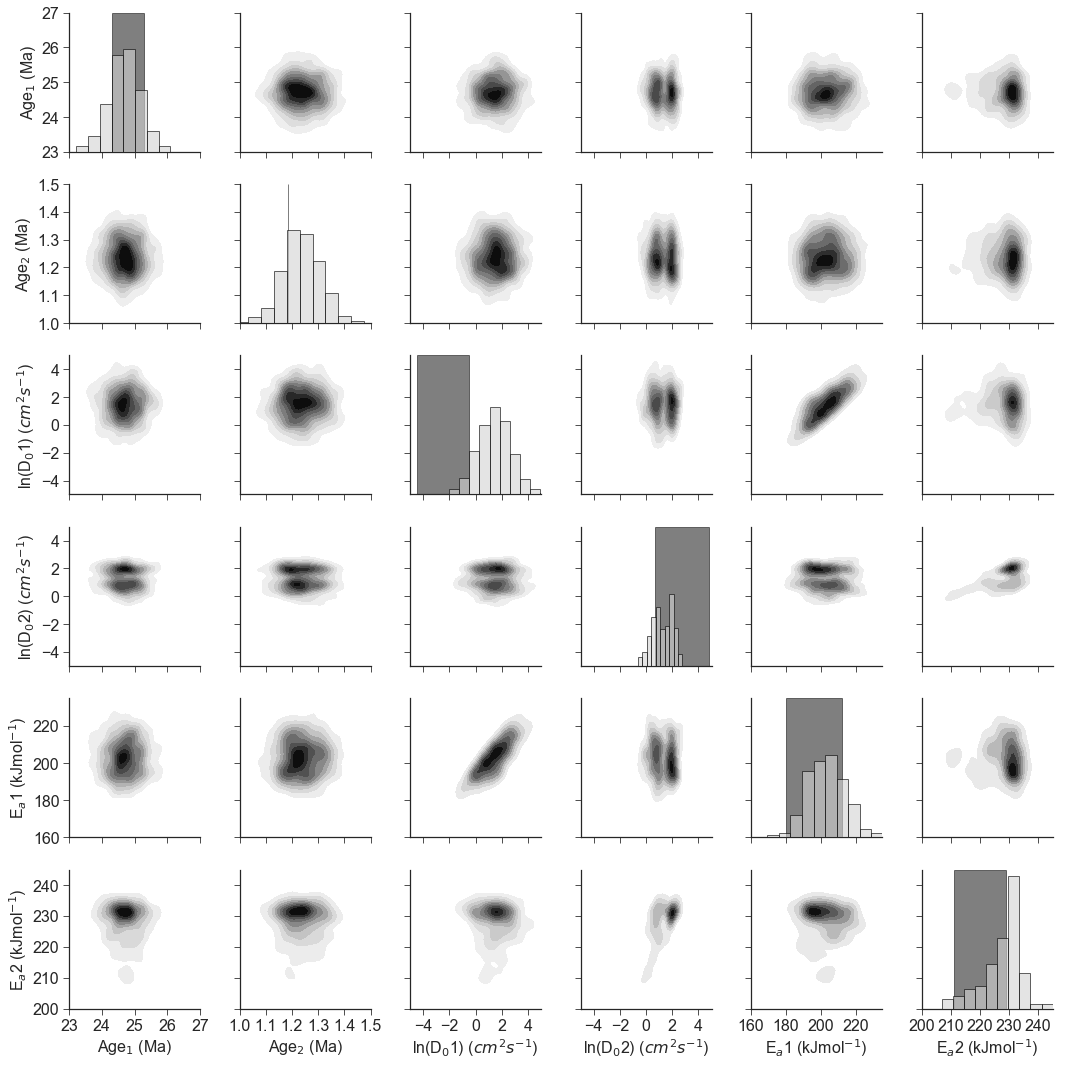

In [52]:
import seaborn as sns
g = sns.PairGrid(df_pairgrid)
g = g.map_diag(plt.hist, facecolor = 'lightgrey', edgecolor = 'k', 
              alpha = 0.6)
g = g.map_offdiag(sns.kdeplot, 
                  shade = True,
                  cmap = 'Greys', 
                 shade_lowest = False)


# Y_AXIS LABELS

g.axes[0,0].set_ylabel('Age$_1$ (Ma)')
g.axes[1,0].set_ylabel('Age$_2$ (Ma)')
g.axes[2,0].set_ylabel('ln(D$_0$1) ($cm^{2}s^{-1}$)')
g.axes[3,0].set_ylabel('ln(D$_0$2) ($cm^{2}s^{-1}$)')
g.axes[4,0].set_ylabel('E$_a$1 (kJmol$^{-1}$)')
g.axes[5,0].set_ylabel('E$_a$2 (kJmol$^{-1}$)')



# X_AXIS LABELS

g.axes[5,0].set_xlabel('Age$_1$ (Ma)')
g.axes[5,1].set_xlabel('Age$_2$ (Ma)')
g.axes[5,2].set_xlabel('ln(D$_0$1) ($cm^{2}s^{-1}$)')
g.axes[5,3].set_xlabel('ln(D$_0$2) ($cm^{2}s^{-1}$)')
g.axes[5,4].set_xlabel('E$_a$1 (kJmol$^{-1}$)')
g.axes[5,5].set_xlabel('E$_a$2 (kJmol$^{-1}$)');


# Set 2 sigma limits

g.axes[0,0].axvspan(24.3,25.3, color = 'k',
                    ymax = 1, 
              alpha = 0.5)
g.axes[1,1].axvspan(1.18482,1.1852, 
                    color = 'k', ymax = 1, 
              alpha = 0.5)
g.axes[2,2].axvspan(-4.5,-0.5, 
                    color = 'k', ymax = 1, 
              alpha = 0.5)
g.axes[3,3].axvspan(0.65,4.83, 
                    color = 'k', ymax = 1, 
              alpha = 0.5)

g.axes[4,4].axvspan(180,212,
                    color = 'k', ymax = 1, 
              alpha = 0.5)

g.axes[5,5].axvspan(211,229, 
                    color = 'k', ymax = 1, 
              alpha = 0.5)


# Set axis limits 
 
g.axes[0,0].set_ylim(23, 27)
g.axes[0,0].locator_params(axis = 'y', nbins = 5)
g.axes[5,0].set_xlim(23, 27)
g.axes[5,0].locator_params(axis = 'x', nbins = 5)


g.axes[1,0].set_ylim(1,1.5)
g.axes[1,0].locator_params(axis = 'y', nbins = 5)
g.axes[5,1].set_xlim(1,1.5)
g.axes[5,1].locator_params(axis = 'x', nbins = 5)



g.axes[2,0].set_ylim(-5,5)
g.axes[2,0].locator_params(axis = 'y', nbins = 5)
g.axes[5,2].set_xlim(-5,5)
g.axes[5,2].locator_params(axis = 'x', nbins = 5)


g.axes[3,0].set_ylim(-5,5)
g.axes[3,0].locator_params(axis = 'y', nbins = 5)
g.axes[5,3].set_xlim(-5,5)
g.axes[5,3].locator_params(axis = 'x', nbins = 5)



g.axes[4,0].set_ylim(160,235)
g.axes[4,0].locator_params(axis = 'y', nbins = 5)
g.axes[5,4].set_xlim(160,235)
g.axes[5,4].locator_params(axis = 'x', nbins = 5)


g.axes[5,0].set_ylim(200,245)
g.axes[5,0].locator_params(axis = 'y', nbins = 5)
g.axes[5,5].set_xlim(200,245)
g.axes[5,5].locator_params(axis = 'x', nbins = 5)

plt.savefig('pairgrid_latest_3_lnd0.pdf')

# Fractional Release Plot

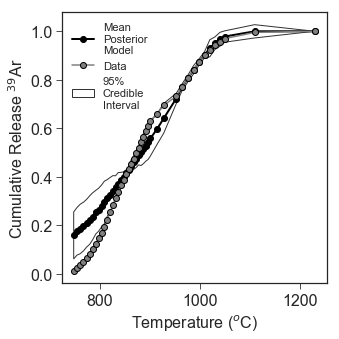

In [78]:
plt.figure(figsize = (5,5))
plt.fill_between(temp, f_low, f_high, 
                  facecolor = 'None', alpha = 0.8, 
                edgecolor = 'k', 
                label = '95%\nCredible\nInterval')

plt.plot(temp, zz1, '-ok', 
          lw = 2, label = 'Mean\nPosterior\nModel')
plt.plot(temp, ww, '-o',
         markerfacecolor= 'grey', 
         markeredgecolor = 'k',
          label = 'Data', 
        color = 'grey')



plt.xlabel('Cumulative $^{39}$Ar Released')
plt.ylabel('Age (Ma)')

plt.xlabel('Temperature ($^{o}$C)')
plt.ylabel('Cumulative Release $^{39}$Ar')
plt.legend(fontsize = 'x-small')
plt.tight_layout()
plt.savefig('Figure4.pdf')